In [1]:
# install libraries

!pip install fastf1 plotly scikit-learn pandas numpy ipywidgets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.4/148.4 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.8/164.8 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 29.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.4/69.4 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 43.2 MB/s eta 0:00:00
  Attempting uninstall: websockets
    Found existing installation: websockets 15.0.1
    Uninstalling websockets-15.0.1:
      Successfully uninstalled websockets-15.0.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dataproc-spark-connect 0.8.2 requires websockets>=14.0, but you have websockets 13.1 which is incompatible.


In [2]:
# imports and cache config
import os
import fastf1
os.makedirs('/content/fastf1_cache', exist_ok=True)
fastf1.Cache.enable_cache('/content/fastf1_cache')

from fastf1 import plotting
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report
import plotly.express as px
import ipywidgets as widgets

# speed up repeated calls
fastf1.Cache.enable_cache('/content/fastf1_cache')
plotting.setup_mpl()


In [3]:
# pulling session data

def get_session_features(year, round_number):
    # load qualifying and race
    quali = fastf1.get_session(year, round_number, 'Q')
    race = fastf1.get_session(year, round_number, 'R')
    quali.load()
    race.load()

    # best qualifying lap times
    q_times = quali.laps.pick_quicklaps().groupby('Driver')['LapTime'].min().reset_index()
    q_times.columns = ['Driver', 'QualBestLap']

    # race pace in clean air: average lap time before first pitstop
    pace = []
    for drv, drv_laps in race.laps.groupby('Driver'):
        first_stop = drv_laps[drv_laps['PitIn'].notna()].LapNumber.min()
        clean = drv_laps[drv_laps.LapNumber < first_stop]
        if not clean.empty:
            avg = clean['LapTime'].mean().total_seconds()
        else:
            avg = np.nan
        pace.append((drv, avg))
    pace = pd.DataFrame(pace, columns=['Driver', 'CleanAirAvgLap'])

    # final positions
    results = race.results[['Driver', 'Position']].copy()

    # combine
    df = q_times.merge(pace, on='Driver').merge(results, on='Driver')
    df['Round'] = round_number
    df['Year'] = year
    return df


In [4]:
# Cell 3: define feature extractor with real column names
def get_session_features(year, round_number):
    # 1) Load sessions
    quali = fastf1.get_session(year, round_number, 'Q'); quali.load()
    race  = fastf1.get_session(year, round_number, 'R'); race.load()

    # 2) Best qualifying lap per driver
    qlaps = quali.laps.pick_quicklaps().reset_index()
    qtimes = (
        qlaps
        .groupby('Driver')['LapTime']
        .min()
        .reset_index(name='QualBestLap')
    )

    # 3) Clean-air race pace = average lap time in stint 1
    laps = race.laps.reset_index()
    pace = (
        laps[laps['Stint'] == 1]
        .groupby('Driver')['LapTime']
        .apply(lambda s: s.dt.total_seconds().mean())
        .reset_index(name='CleanAirAvgLap')
    )

    # 4) Finishing positions: Abbreviation → Driver, use Position
    res = race.results.reset_index()
    res = res.rename(columns={'Abbreviation': 'Driver'})
    results = res[['Driver', 'Position']]

    # 5) Merge all features
    df = qtimes.merge(pace, on='Driver').merge(results, on='Driver')
    df['Year']  = year
    df['Round'] = round_number
    return df


In [5]:
import fastf1
from fastf1.core import DataNotLoadedError
import pandas as pd

# ← define your season here
year = 2025


In [6]:
from fastf1.core import DataNotLoadedError

# get schedule and drop the test round
schedule = fastf1.get_event_schedule(year)
rounds   = [r for r in schedule.index if r > 0]

season_list = []
for r in rounds:
    try:
        df = get_session_features(year, r)
        season_list.append(df)
    except DataNotLoadedError:
        print(f"Skipping round {r} (no data yet)")

season_data = pd.concat(season_list, ignore_index=True)
season_data.head()


core           INFO 	Loading data for Australian Grand Prix - Qualifying [v3.6.0]
INFO:fastf1.fastf1.core:Loading data for Australian Grand Prix - Qualifying [v3.6.0]
req            INFO 	No cached data found for session_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
INFO:fastf1.api:Fetching session info data...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
INFO:fastf1.api:Fetching driver list...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
DEBUG:fastf1.ergast:Failed to parse timestamp '' in Ergastresponse.
req            INFO 	No cached data found for session_status_

Skipping round 13 (no data yet)


DEBUG:fastf1.api:Falling back to livetiming mirror (https://livetiming-mirror.fastf1.dev)
logger      WARNING 	Failed to load session info data!
DEBUG:fastf1.fastf1.core:Traceback for failure in session info data
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/fastf1/logger.py", line 151, in __wrapped
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/fastf1/core.py", line 1471, in _load_session_info
    self._session_info = api.session_info(self.api_path,
                         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/fastf1/req.py", line 479, in _cached_api_request
    data = func(api_path, **func_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/fastf1/_api.py", line 1714, in session_info
    raise SessionNotAvailableError(
fastf1._api.SessionNotAvailableError: No data for this session! If this sessi

Skipping round 14 (no data yet)


DEBUG:fastf1.api:Falling back to livetiming mirror (https://livetiming-mirror.fastf1.dev)
logger      WARNING 	Failed to load session info data!
DEBUG:fastf1.fastf1.core:Traceback for failure in session info data
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/fastf1/logger.py", line 151, in __wrapped
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/fastf1/core.py", line 1471, in _load_session_info
    self._session_info = api.session_info(self.api_path,
                         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/fastf1/req.py", line 479, in _cached_api_request
    data = func(api_path, **func_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/fastf1/_api.py", line 1714, in session_info
    raise SessionNotAvailableError(
fastf1._api.SessionNotAvailableError: No data for this session! If this sessi

Skipping round 15 (no data yet)


DEBUG:fastf1.api:Falling back to livetiming mirror (https://livetiming-mirror.fastf1.dev)
logger      WARNING 	Failed to load session info data!
DEBUG:fastf1.fastf1.core:Traceback for failure in session info data
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/fastf1/logger.py", line 151, in __wrapped
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/fastf1/core.py", line 1471, in _load_session_info
    self._session_info = api.session_info(self.api_path,
                         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/fastf1/req.py", line 479, in _cached_api_request
    data = func(api_path, **func_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/fastf1/_api.py", line 1714, in session_info
    raise SessionNotAvailableError(
fastf1._api.SessionNotAvailableError: No data for this session! If this sessi

Skipping round 16 (no data yet)


DEBUG:fastf1.api:Falling back to livetiming mirror (https://livetiming-mirror.fastf1.dev)
logger      WARNING 	Failed to load session info data!
DEBUG:fastf1.fastf1.core:Traceback for failure in session info data
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/fastf1/logger.py", line 151, in __wrapped
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/fastf1/core.py", line 1471, in _load_session_info
    self._session_info = api.session_info(self.api_path,
                         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/fastf1/req.py", line 479, in _cached_api_request
    data = func(api_path, **func_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/fastf1/_api.py", line 1714, in session_info
    raise SessionNotAvailableError(
fastf1._api.SessionNotAvailableError: No data for this session! If this sessi

Skipping round 17 (no data yet)


DEBUG:fastf1.api:Falling back to livetiming mirror (https://livetiming-mirror.fastf1.dev)
logger      WARNING 	Failed to load session info data!
DEBUG:fastf1.fastf1.core:Traceback for failure in session info data
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/fastf1/logger.py", line 151, in __wrapped
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/fastf1/core.py", line 1471, in _load_session_info
    self._session_info = api.session_info(self.api_path,
                         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/fastf1/req.py", line 479, in _cached_api_request
    data = func(api_path, **func_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/fastf1/_api.py", line 1714, in session_info
    raise SessionNotAvailableError(
fastf1._api.SessionNotAvailableError: No data for this session! If this sessi

Skipping round 18 (no data yet)


logger      WARNING 	Failed to load session info data!
DEBUG:fastf1.fastf1.core:Traceback for failure in session info data
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/fastf1/logger.py", line 151, in __wrapped
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/fastf1/core.py", line 1471, in _load_session_info
    self._session_info = api.session_info(self.api_path,
                         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/fastf1/req.py", line 479, in _cached_api_request
    data = func(api_path, **func_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/fastf1/_api.py", line 1712, in session_info
    response = fetch_page(path, 'session_info')
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/fastf1/_api.py", line 1752, in fetch_page
    r = Cache.req

Skipping round 19 (no data yet)


logger      WARNING 	Failed to load session info data!
DEBUG:fastf1.fastf1.core:Traceback for failure in session info data
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/fastf1/logger.py", line 151, in __wrapped
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/fastf1/core.py", line 1471, in _load_session_info
    self._session_info = api.session_info(self.api_path,
                         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/fastf1/req.py", line 479, in _cached_api_request
    data = func(api_path, **func_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/fastf1/_api.py", line 1712, in session_info
    response = fetch_page(path, 'session_info')
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/fastf1/_api.py", line 1752, in fetch_page
    r = Cache.req

Skipping round 20 (no data yet)


logger      WARNING 	Failed to load session info data!
DEBUG:fastf1.fastf1.core:Traceback for failure in session info data
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/fastf1/logger.py", line 151, in __wrapped
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/fastf1/core.py", line 1471, in _load_session_info
    self._session_info = api.session_info(self.api_path,
                         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/fastf1/req.py", line 479, in _cached_api_request
    data = func(api_path, **func_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/fastf1/_api.py", line 1712, in session_info
    response = fetch_page(path, 'session_info')
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/fastf1/_api.py", line 1752, in fetch_page
    r = Cache.req

Skipping round 21 (no data yet)


logger      WARNING 	Failed to load session info data!
DEBUG:fastf1.fastf1.core:Traceback for failure in session info data
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/fastf1/logger.py", line 151, in __wrapped
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/fastf1/core.py", line 1471, in _load_session_info
    self._session_info = api.session_info(self.api_path,
                         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/fastf1/req.py", line 479, in _cached_api_request
    data = func(api_path, **func_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/fastf1/_api.py", line 1712, in session_info
    response = fetch_page(path, 'session_info')
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/fastf1/_api.py", line 1752, in fetch_page
    r = Cache.req

Skipping round 22 (no data yet)


logger      WARNING 	Failed to load session info data!
DEBUG:fastf1.fastf1.core:Traceback for failure in session info data
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/fastf1/logger.py", line 151, in __wrapped
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/fastf1/core.py", line 1471, in _load_session_info
    self._session_info = api.session_info(self.api_path,
                         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/fastf1/req.py", line 479, in _cached_api_request
    data = func(api_path, **func_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/fastf1/_api.py", line 1712, in session_info
    response = fetch_page(path, 'session_info')
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/fastf1/_api.py", line 1752, in fetch_page
    r = Cache.req

Skipping round 23 (no data yet)


logger      WARNING 	Failed to load session info data!
DEBUG:fastf1.fastf1.core:Traceback for failure in session info data
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/fastf1/logger.py", line 151, in __wrapped
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/fastf1/core.py", line 1471, in _load_session_info
    self._session_info = api.session_info(self.api_path,
                         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/fastf1/req.py", line 479, in _cached_api_request
    data = func(api_path, **func_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/fastf1/_api.py", line 1712, in session_info
    response = fetch_page(path, 'session_info')
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/fastf1/_api.py", line 1752, in fetch_page
    r = Cache.req

Skipping round 24 (no data yet)


,Driver,QualBestLap,CleanAirAvgLap,Position,Year,Round
0,ALB,0 days 00:01:15.737000,132.195,5.0,2025,1
1,ALO,0 days 00:01:16.288000,137.178,17.0,2025,1
2,ANT,0 days 00:01:16.525000,142.352,4.0,2025,1
3,BOR,0 days 00:01:16.516000,144.063,16.0,2025,1
4,DOO,0 days 00:01:16.315000,NaN,19.0,2025,1


In [7]:
# Cell 6: Add per‐team performance (with TeamColor) and export for Streamlit

from fastf1.core import DataNotLoadedError
import pickle

points_list = []
for r in rounds:
    try:
        race = fastf1.get_session(year, r, 'R')
        race.load(laps=False, telemetry=False, weather=False, messages=False)
    except DataNotLoadedError:
        continue

    # include TeamColor here
    df = race.results.reset_index()[[
        'Abbreviation','TeamName','TeamColor','Points'
    ]].rename(columns={
        'Abbreviation':'Driver',
        'TeamName'    :'Team',
        'TeamColor'   :'TeamColor',
        'Points'      :'RacePts'
    })
    df['Round'] = r
    points_list.append(df)

points_df = pd.concat(points_list, ignore_index=True)
# cumulative season points
points_df['SeasonPts'] = points_df.groupby('Team')['RacePts'].cumsum()

# export points_df
points_df.to_pickle('points_df.pkl')

# build and export a driver→team‐color map
team_color_map = points_df.groupby('Driver')['TeamColor'].last().to_dict()
with open('team_color_map.pkl','wb') as f:
    pickle.dump(team_color_map, f)

# Finally, export season_data if you haven't already
season_data.to_pickle('season_data.pkl')


core           INFO 	Loading data for Australian Grand Prix - Race [v3.6.0]
INFO:fastf1.fastf1.core:Loading data for Australian Grand Prix - Race [v3.6.0]
req            INFO 	Using cached data for session_info
INFO:fastf1.fastf1.req:Using cached data for session_info
req            INFO 	Using cached data for driver_info
INFO:fastf1.fastf1.req:Using cached data for driver_info
core           INFO 	Finished loading data for 20 drivers: ['4', '1', '63', '12', '23', '18', '27', '16', '81', '44', '10', '22', '31', '87', '30', '5', '14', '55', '7', '6']
INFO:fastf1.fastf1.core:Finished loading data for 20 drivers: ['4', '1', '63', '12', '23', '18', '27', '16', '81', '44', '10', '22', '31', '87', '30', '5', '14', '55', '7', '6']
core           INFO 	Loading data for Chinese Grand Prix - Race [v3.6.0]
INFO:fastf1.fastf1.core:Loading data for Chinese Grand Prix - Race [v3.6.0]
req            INFO 	Using cached data for session_info
INFO:fastf1.fastf1.req:Using cached data for session_info
req

In [8]:
# persist season_data so Streamlit can load it
season_data.to_pickle('season_data.pkl')


In [9]:
# Make sure each row in season_data has a Team by merging from points_df
# (points_df only has Round, Driver, Team—no Year column)
print("points_df columns:", points_df.columns.tolist())

season_data = season_data.merge(
    points_df[['Round','Driver','Team']],
    on=['Round','Driver'],
    how='left'
)

# Quick check
print("season_data columns now:", season_data.columns.tolist())
print(season_data[['Round','Driver','Team']].head())


points_df columns: ['Driver', 'Team', 'TeamColor', 'RacePts', 'Round', 'SeasonPts']
season_data columns now: ['Driver', 'QualBestLap', 'CleanAirAvgLap', 'Position', 'Year', 'Round', 'Team']
   Round Driver          Team
0      1    ALB      Williams
1      1    ALO  Aston Martin
2      1    ANT      Mercedes
3      1    BOR   Kick Sauber
4      1    DOO        Alpine


In [10]:
# ── Bring SeasonPts into season_data ──
# points_df has Round, Driver, SeasonPts (cumulative after each GP)
print("Before merge:", season_data.columns.tolist())

season_data = season_data.merge(
    points_df[['Round','Driver','SeasonPts']],
    on=['Round','Driver'],
    how='left'
)

print("After merge:", season_data.columns.tolist())
# Quick peek
season_data[['Round','Driver','SeasonPts']].drop_duplicates().head()


Before merge: ['Driver', 'QualBestLap', 'CleanAirAvgLap', 'Position', 'Year', 'Round', 'Team']
After merge: ['Driver', 'QualBestLap', 'CleanAirAvgLap', 'Position', 'Year', 'Round', 'Team', 'SeasonPts']


,Round,Driver,SeasonPts
0,1,ALB,10.0
1,1,ALO,8.0
2,1,ANT,27.0
3,1,BOR,6.0
4,1,DOO,0.0


In [11]:
# Cell 7: Preprocess, encode, scale, and split
df = season_data.dropna().copy()
df['QualBestLap'] = df['QualBestLap'].dt.total_seconds()

from sklearn.preprocessing import LabelEncoder, StandardScaler
driver_enc = LabelEncoder().fit(df['Driver'])
df['DriverEnc'] = driver_enc.transform(df['Driver'])
team_enc = LabelEncoder().fit(df['Team'])
df['TeamEnc'] = team_enc.transform(df['Team'])

X = df[['QualBestLap','CleanAirAvgLap','SeasonPts','DriverEnc','TeamEnc']]
y = (df['Position'] <= 3).astype(int)

scaler = StandardScaler()
X[['QualBestLap','CleanAirAvgLap','SeasonPts']] = scaler.fit_transform(
    X[['QualBestLap','CleanAirAvgLap','SeasonPts']]
)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train:", X_train.shape, y_train.shape)
print("Test: ", X_test.shape,  y_test.shape)


Train: (181, 5) (181,)
Test:  (46, 5) (46,)


/tmp/ipython-input-11-326830739.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[['QualBestLap','CleanAirAvgLap','SeasonPts']] = scaler.fit_transform(


In [12]:
# Cell 8 (alternate): using pivot_table

team_curve = (
    points_df
    .pivot_table(
        index='Round',
        columns='Team',
        values='SeasonPts',
        aggfunc='max'
    )
    .fillna(method='ffill')
    .fillna(0)
)

import plotly.express as px
fig = px.line(
    team_curve,
    x=team_curve.index,
    y=team_curve.columns,
    title="Team Championship Standings Over Rounds",
    labels={'value':'Cumulative Points','Round':'GP Round'}
)
fig.update_layout(legend_title_text='Team')
fig.show()



/tmp/ipython-input-12-1790802445.py:11: FutureWarning: SessionResults.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .fillna(method='ffill')


In [13]:
from sklearn.ensemble import RandomForestClassifier

# … after you’ve prepared X_train, y_train …
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

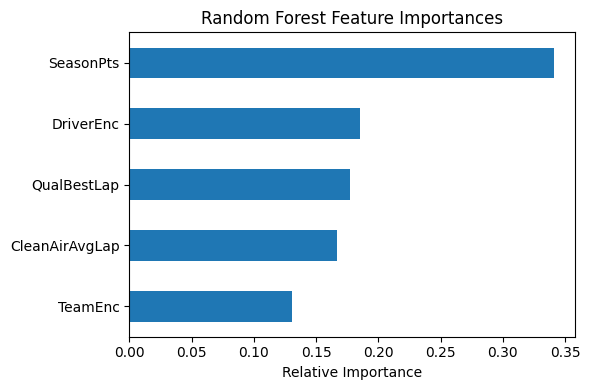

In [14]:
# Quick RF feature importances (assumes `model` is already defined)
import matplotlib.pyplot as plt
import pandas as pd

feature_names = ['QualBestLap','CleanAirAvgLap','SeasonPts','DriverEnc','TeamEnc']
imp_series = pd.Series(
    model.feature_importances_,
    index=feature_names
).sort_values()

plt.figure(figsize=(6,4))
imp_series.plot(kind='barh')
plt.title("Random Forest Feature Importances")
plt.xlabel("Relative Importance")
plt.tight_layout()
plt.show()


In [15]:
# Cell: Driver average position over last 3 rounds
import plotly.express as px
import numpy as np

last3 = sorted(season_data['Round'].unique())[-3:]
form = []
for drv, g in season_data.groupby('Driver'):
    pts = []
    for r in last3:
        row = g[g.Round==r]
        if not row.empty:
            pts.append(row.Position.iloc[0])
    if pts:
        form.append({'Driver':drv, 'AvgFinPos': np.mean(pts)})

form_df = pd.DataFrame(form).sort_values('AvgFinPos')
fig = px.bar(
    form_df, x='Driver', y='AvgFinPos',
    title="Avg Finishing Position · Last 3 Races",
    labels={'AvgFinPos':'Average Position'}
)
fig.update_yaxes(autorange="reversed")  # 1st at top
fig.show()


In [16]:
# Cell: Team points evolution
import plotly.express as px

team_round = (
    points_df
    .groupby(['Round','Team'], as_index=False)
    .agg(SeasonPts=('SeasonPts','max'))
)
team_curve = team_round.pivot(
    index='Round', columns='Team', values='SeasonPts'
).fillna(method='ffill').fillna(0)

fig = px.line(
    team_curve, x=team_curve.index, y=team_curve.columns,
    title="Team Championship Over Rounds",
    labels={'value':'Points','Round':'GP Round'}
)
fig.update_layout(legend_title_text='Team')
fig.show()


/tmp/ipython-input-16-1492253999.py:11: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



In [17]:
# Cell 8: Train and evaluate the model

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# instantiate and train
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# make predictions on test set
y_pred = model.predict(X_test)

# evaluation
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.90      0.97      0.94        39
           1       0.75      0.43      0.55         7

    accuracy                           0.89        46
   macro avg       0.83      0.70      0.74        46
weighted avg       0.88      0.89      0.88        46



In [18]:
# Cell 9: Blind pre-race predictions for Belgian GP (R13), with timedelta fix

import pandas as pd

# 1) Aggregate each driver’s season stats
driver_stats = (
    season_data
    .groupby('Driver')
    .agg(
        QualBestLap    = ('QualBestLap',    'mean'),
        CleanAirAvgLap = ('CleanAirAvgLap', 'mean'),
        SeasonPts      = ('SeasonPts',      'max')
    )
    .reset_index()
)

# 2) Convert QualBestLap from timedelta → float seconds
driver_stats['QualBestLap'] = driver_stats['QualBestLap'].dt.total_seconds()

# 3) Encode categorical features
driver_stats['DriverEnc'] = driver_enc.transform(driver_stats['Driver'])
# pull each driver’s team from points_df
team_map = points_df.groupby('Driver')['Team'].last()
driver_stats['TeamEnc'] = team_enc.transform(team_map.loc[driver_stats['Driver']].values)

# 4) Build feature matrix
X_blind = driver_stats[['QualBestLap','CleanAirAvgLap','SeasonPts','DriverEnc','TeamEnc']]

# 5) Scale numeric columns
X_blind[['QualBestLap','CleanAirAvgLap','SeasonPts']] = scaler.transform(
    X_blind[['QualBestLap','CleanAirAvgLap','SeasonPts']]
)

# 6) Predict podium probability
driver_stats['PodiumProb'] = model.predict_proba(X_blind)[:,1]

# 7) Show top 10 for Belgian GP
driver_stats.sort_values('PodiumProb', ascending=False)[['Driver','PodiumProb']].head(10)


/tmp/ipython-input-18-979834883.py:30: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Driver,PodiumProb
15,PIA,0.84
13,NOR,0.80
20,VER,0.28
16,RUS,0.26
12,LEC,0.24
10,HUL,0.20
2,ANT,0.16
9,HAM,0.10
19,TSU,0.06
4,BOR,0.05


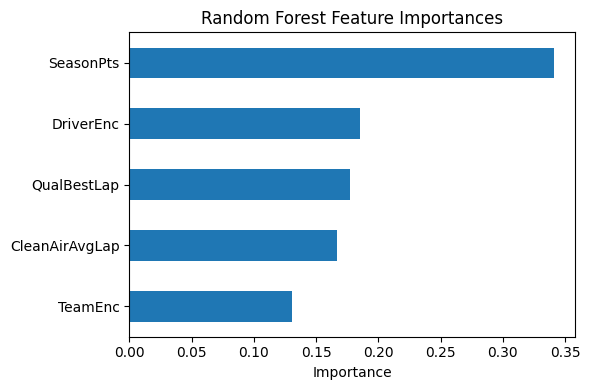

In [19]:
# Cell 11: Feature importances
import matplotlib.pyplot as plt
import numpy as np

# pull importances and sort
imp = pd.Series(model.feature_importances_, index=X_train.columns)
imp = imp.sort_values()

# horizontal bar plot
plt.figure(figsize=(6,4))
imp.plot(kind='barh')
plt.title('Random Forest Feature Importances')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()


In [20]:
# Cell 12: Hyperparameter tuning
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'max_depth':    [None, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid = GridSearchCV(
    RandomForestClassifier(random_state=42, class_weight='balanced'),
    param_grid,
    cv=3,
    scoring='f1',
    n_jobs=-1
)
grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
best_model = grid.best_estimator_

# Re-evaluate
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))



Best params: {'max_depth': None, 'min_samples_leaf': 4, 'n_estimators': 200}
              precision    recall  f1-score   support

           0       0.90      0.95      0.93        39
           1       0.60      0.43      0.50         7

    accuracy                           0.87        46
   macro avg       0.75      0.69      0.71        46
weighted avg       0.86      0.87      0.86        46



In [21]:
y = df['Position']


In [22]:
!pip install streamlit pyngrok


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 62.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 102.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 8.3 MB/s eta 0:00:00


In [23]:
import pickle

# Save model, encoders, scaler
with open('rf_model.pkl','wb') as f:
    pickle.dump(model, f)
with open('driver_enc.pkl','wb') as f:
    pickle.dump(driver_enc, f)
with open('team_enc.pkl','wb') as f:
    pickle.dump(team_enc, f)
with open('scaler.pkl','wb') as f:
    pickle.dump(scaler, f)
# Also save points_df if needed
points_df.to_pickle('points_df.pkl')


In [24]:
# Install pyngrok if you haven’t already
!pip install pyngrok

# Configure ngrok with your auth token
!ngrok authtoken 2zeKICFloN5zlvvHQFskEJPun4z_2QB4iC14BsCs34g8d8J6Y



Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [25]:
import shap
# after model is loaded...
explainer = shap.TreeExplainer(model)


In [26]:
%%bash
cat > app.py << 'EOF'
import streamlit as st
import pandas as pd
import pickle
import numpy as np
import fastf1
import plotly.express as px
import shap
import matplotlib.pyplot as plt

# --- Configuration ---
year = 2025
st.set_page_config(page_title="🏁 F1 Podium Predictor", layout="wide")
st.sidebar.header("Display Settings")
top_n = st.sidebar.slider("Show top N drivers", 3, 20, 10)

# --- Load artifacts & data ---
model          = pickle.load(open('rf_model.pkl','rb'))
driver_enc     = pickle.load(open('driver_enc.pkl','rb'))
team_enc       = pickle.load(open('team_enc.pkl','rb'))
scaler         = pickle.load(open('scaler.pkl','rb'))
points_df      = pd.read_pickle('points_df.pkl')
season_data    = pd.read_pickle('season_data.pkl')
team_color_map = pickle.load(open('team_color_map.pkl','rb'))

# ─── Patch: convert timedelta columns to seconds ───
for col in ("QualBestLap","CleanAirAvgLap"):
    if pd.api.types.is_timedelta64_dtype(season_data[col]):
        season_data[col] = season_data[col].dt.total_seconds()

# Ensure hex colors
team_color_map = {d:('#'+c if not c.startswith('#') else c)
                  for d,c in team_color_map.items()}

# Build a SHAP TreeExplainer once
explainer = shap.TreeExplainer(model)

# --- Prediction helper ---
def predict_podium_for_round(rnd):
    try:
        sess = fastf1.get_session(year, rnd, "Q", backend="ergast")
        sess.load(laps=True, telemetry=False, weather=False, messages=False)
        laps = sess.laps.pick_quicklaps().reset_index()
        qtimes = (
            laps.groupby("Driver")["LapTime"]
                .min().dt.total_seconds()
                .reset_index(name="QualBestLap")
        )
    except:
        qtimes = (
            season_data
              .groupby("Driver")["QualBestLap"]
              .mean()
              .reset_index(name="QualBestLap")
        )
    pace = (
        season_data
          .groupby("Driver")["CleanAirAvgLap"]
          .mean()
          .reset_index(name="CleanAirAvgLap")
    )
    pts = (
        points_df
          .groupby("Driver")["SeasonPts"]
          .last()
          .reset_index(name="SeasonPts")
    )
    df = qtimes.merge(pace, on="Driver").merge(pts, on="Driver")
    df["DriverEnc"] = driver_enc.transform(df["Driver"])
    last_teams      = points_df.groupby("Driver")["Team"].last()
    df["TeamEnc"]   = team_enc.transform(df["Driver"].map(last_teams))
    df[["QualBestLap","CleanAirAvgLap","SeasonPts"]] = scaler.transform(
        df[["QualBestLap","CleanAirAvgLap","SeasonPts"]]
    )
    X = df[["QualBestLap","CleanAirAvgLap","SeasonPts","DriverEnc","TeamEnc"]]
    df["PodiumProb"] = model.predict_proba(X)[:,1]
    df["TeamColor"]  = df["Driver"].map(team_color_map)
    return df.sort_values("PodiumProb", ascending=False)

# Upcoming rounds & medals
rounds = [13,14,15]
medals = ["🥇","🥈","🥉"]

# --- What‐If Simulator in sidebar ---
st.sidebar.header("🔧 What‐If Simulator")
sim_round  = st.sidebar.selectbox("Pick Round", rounds,
                  format_func=lambda r: f"Round {r}")
st.sidebar.markdown(f"#### Simulating on Round {sim_round}")
sim_driver = st.sidebar.selectbox("Pick Driver",
                  season_data["Driver"].unique())
sim_qual   = st.sidebar.slider("Δ QualBestLap (s)", -1.0, 1.0, 0.0, step=0.01)
sim_pts    = st.sidebar.slider("Δ SeasonPts", -30, 30, 0, step=1)

base_df = predict_podium_for_round(sim_round)
row     = base_df[base_df.Driver==sim_driver].iloc[0].copy()
row.QualBestLap += sim_qual
row.SeasonPts   += sim_pts

scaled_nums = scaler.transform([[
    row.QualBestLap,
    row.CleanAirAvgLap,
    row.SeasonPts
]])
X_sim = np.hstack([scaled_nums, [[row.DriverEnc, row.TeamEnc]]])
sim_prob = model.predict_proba(X_sim)[0,1]
st.sidebar.markdown(f"**{sim_driver} → {sim_prob:.0%}**")

# --- Page Title & Tabs ---
st.markdown("<h1 style='text-align:center;'>🏁 F1 Podium Predictor · Next 3 GPs 🏁</h1>",
            unsafe_allow_html=True)
tabs = st.tabs(["📖 About","🔍 Insights","🇧🇪 Belgian GP",
                "🇭🇺 Hungarian GP","🇳🇱 Dutch GP"])

# --- About Tab ---
with tabs[0]:
    st.header("How It Works")
    st.markdown("""
We predict podium (top-3) finishes using a **Random Forest** trained on:
- **QualBestLap** (sec)
- **CleanAirAvgLap** (sec)
- **SeasonPts** (points)
- **DriverEnc**, **TeamEnc** (categorical)

All numeric features are standardized; model validated via 5-fold CV.
    """)
    st.image("https://media.giphy.com/media/Vi6TA5a01GhLVndS7i/giphy.gif", width=300)

# --- Insights Tab ---
with tabs[1]:
    st.header("🔍 Key Insights")
    fi = pd.DataFrame({
        "Feature": model.feature_names_in_,
        "Importance": model.feature_importances_
    }).sort_values("Importance")
    fig1 = px.bar(fi, x="Importance", y="Feature",
                  orientation="h", title="Feature Importances",
                  color="Feature",
                  color_discrete_sequence=px.colors.qualitative.Plotly)
    fig1.update_traces(width=0.6)
    st.plotly_chart(fig1, use_container_width=True)

    last3 = sorted(season_data["Round"].unique())[-3:]
    form = []
    for d,grp in season_data.groupby("Driver"):
        pos = [grp[grp.Round==r]["Position"].iloc[0]
               for r in last3 if not grp[grp.Round==r].empty]
        if pos:
            form.append({"Driver": d, "AvgFinPos": np.mean(pos)})
    form_df = pd.DataFrame(form).sort_values("AvgFinPos")
    fig2 = px.bar(form_df, x="Driver", y="AvgFinPos",
                  title="Avg Finishing Position · Last 3 Races",
                  color="Driver",
                  color_discrete_map=team_color_map)
    fig2.update_traces(width=0.6)
    fig2.update_yaxes(autorange="reversed")
    st.plotly_chart(fig2, use_container_width=True)

# --- GP Tabs + SHAP Waterfall ---
for idx, rnd in enumerate(rounds, start=2):
    with tabs[idx]:
        st.subheader(f"Round {rnd} Predictions")
        preds = predict_podium_for_round(rnd)

        #  Top 3
        top3 = preds.head(3)
        cols = st.columns(3)
        for i,(_,r) in enumerate(top3.iterrows()):
            cols[i].markdown(f"## {medals[i]} {r.Driver}")
            cols[i].markdown(f"**{r.PodiumProb:.0%}**")

        #  Bar chart
        topN = preds.head(top_n)
        fig3 = px.bar(topN, x="Driver", y="PodiumProb",
                      title=f"Top {top_n} Podium Probabilities",
                      color="Driver",
                      color_discrete_map=team_color_map)
        fig3.update_traces(width=0.6)
        fig3.update_layout(yaxis_tickformat=".0%", showlegend=False)
        st.plotly_chart(fig3, use_container_width=True,
                        key=f"podium_chart_{rnd}")

        #  Data table
        st.dataframe(topN[["Driver","PodiumProb","SeasonPts"]],
                     use_container_width=True)

        #  Team total points
        totals = (points_df.groupby("Team",as_index=False)["SeasonPts"]
                       .max().sort_values("SeasonPts",ascending=False))
        fig4 = px.bar(totals, x="Team", y="SeasonPts",
                      title="Team Total Points (Season)",
                      color="Team",
                      color_discrete_map={
                        t:team_color_map[d]
                        for t,d in points_df.drop_duplicates("Team")[["Team","Driver"]].values
                      })
        fig4.update_traces(width=0.6)
        st.plotly_chart(fig4, use_container_width=True,
                        key=f"teamtotals_chart_{rnd}")

        #  Why these three?
        st.markdown("**Why these three?**")
        for d,ql,cl,pt,pr in preds.head(3)[
            ["Driver","QualBestLap","CleanAirAvgLap","SeasonPts","PodiumProb"]
        ].itertuples(index=False):
            st.markdown(f"- **{d}**: Q⇒{ql:.1f}s, Pace⇒{cl:.1f}s, "
                        f"Pts⇒{int(pt)} → **{pr:.0%}**")

        #  SHAP Waterfall explainer
        driver_to_explain = st.selectbox(
            "Explain prediction for…",
            preds["Driver"].head(top_n),
            key=f"shap_driver_{rnd}"
        )
        row = preds.query("Driver == @driver_to_explain").iloc[0]
        vals = np.array([[row.QualBestLap,
                          row.CleanAirAvgLap,
                          row.SeasonPts,
                          row.DriverEnc,
                          row.TeamEnc]])
        raw = explainer.shap_values(vals)
        # Handle list (binary) or ndarray
        if isinstance(raw, list):
            # raw = [class0_vals, class1_vals]
            shap_vec = raw[1][0]
            exp_val  = explainer.expected_value[1]
        elif raw.ndim == 3:
            # shape = (1,classes,features)
            shap_vec = raw[0,1,:]
            exp_val  = explainer.expected_value[1]
        else:
            # single-output
            shap_vec = raw[0]
            exp_val  = explainer.expected_value
        # draw waterfall
        fig_w = shap.plots._waterfall.waterfall_legacy(
            exp_val, shap_vec,
            feature_names=["QualBestLap","CleanAirAvgLap",
                           "SeasonPts","DriverEnc","TeamEnc"],
            show=False
        )
        st.pyplot(fig_w)

EOF


In [27]:
# 1) Start Streamlit in the background on port 8501
get_ipython().system_raw(
    'streamlit run app.py --server.port 8501 --server.enableCORS false &'
)

# 2) Wait up to 15 seconds for it to come up
import time
for i in range(15):
    time.sleep(1)

# 3) Get and print the Colab proxy URL
from google.colab import output
url = output.eval_js("google.colab.kernel.proxyPort(8501)")
print("▶️ Your dashboard is live at:", url)


▶️ Your dashboard is live at: https://8501-m-s-1ex7u5hpjcc51-b.us-west3-0.prod.colab.dev
